In [1]:
import caffe
from pylab import *
%matplotlib inline

In [2]:
import os

caffe_root = '/data3/ludi/local/caffe'
os.chdir(caffe_root)
!data/mnist/get_mnist.sh
!examples/mnist/create_mnist.sh
os.chdir('examples')

Downloading...
Creating lmdb...
I1009 17:31:19.358573  3483 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_train_lmdb
I1009 17:31:19.369945  3483 convert_mnist_data.cpp:88] A total of 60000 items.
I1009 17:31:19.369962  3483 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I1009 17:31:20.541496  3483 convert_mnist_data.cpp:108] Processed 60000 files.
I1009 17:31:21.629323  3538 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_test_lmdb
I1009 17:31:21.629778  3538 convert_mnist_data.cpp:88] A total of 10000 items.
I1009 17:31:21.629801  3538 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I1009 17:31:21.834710  3538 convert_mnist_data.cpp:108] Processed 10000 files.
Done.


In [8]:
from caffe import layers as L, params as P

def lenet(lmdb, batch_size):
    
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb, 
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

with open('mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))
    
with open('mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb', 100)))

In [12]:
!cat mnist/lenet_auto_solver.prototxt

# The train/test net protocol buffer definition
train_net: "mnist/lenet_auto_train.prototxt"
test_net: "mnist/lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "mnist/lenet"


In [11]:
caffe.set_device(0)
caffe.set_mode_gpu()

solver = caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

In [13]:
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

In [18]:
[(k, v[0].data.shape, v[1].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5), (20,)),
 ('conv2', (50, 20, 5, 5), (50,)),
 ('fc1', (500, 800), (500,)),
 ('score', (10, 500), (10,))]

In [23]:
solver.net.forward()
solver.test_nets[0].forward()

{'loss': array(2.442587375640869, dtype=float32)}

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


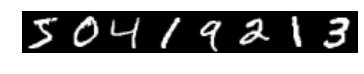

In [26]:
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


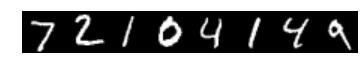

In [27]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]

In [28]:
solver.step(1)

(-0.5, 24.5, 19.5, -0.5)

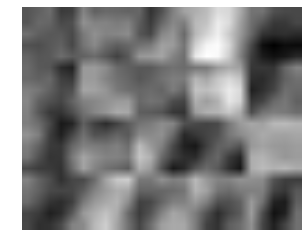

In [34]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); axis('off')

In [35]:
%%time
niter = 200
test_interval = 25
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

for it in range(niter):
    solver.step(1)
    
    train_loss[it] = solver.net.blobs['loss'].data
    
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in xrange(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
            test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 12.4 s, sys: 1.18 s, total: 13.6 s
Wall time: 12.6 s


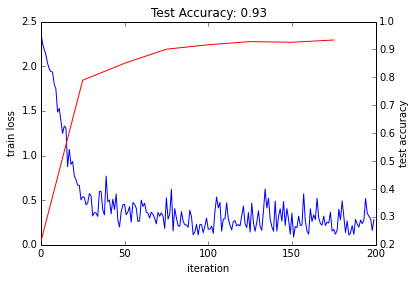

In [36]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))